**Определение возраста покупателей**

Цель проекта - система компьютерного зрения для обработкии фотографий покупателей магазина для определения их возраста.
Это позволит анализировать покупки и предлагать товары, актуальные для этой возрастной группы, а также котролировать продажу алкоголя


План работы: 
1. Выполнить исследовательский анализ:
    - загрузить библиотеки
    - загрузить данные
    - посмотреть записи в датафрейме
    - посмотореть инфо и статистику по данным
    - вывести часть фото
2. Обучение модели
    - создать функцию загрузки обучающей выборки 
    - создать функцию загрузки тестовой выборки 
    - создать модель с архитектурой ResNet50
    - обучить модель с метрикой качества MAE менее 8 
3. Анализ обученной модели    

# Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [3]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Размет выборки 7591 фото, для обучения модели нет необходимости замораживать слои ResNet50

<AxesSubplot:>

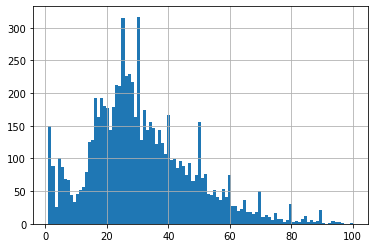

In [5]:
labels['real_age'].hist(bins=100)

На гистограмме имеются выбросы; в области возраста 5-15 лет имеется провал на гистограмме

In [6]:
%%time
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 
features_train, target_train = next(train_gen_flow)

Found 7591 validated image filenames.
CPU times: user 758 ms, sys: 411 ms, total: 1.17 s
Wall time: 1min 29s


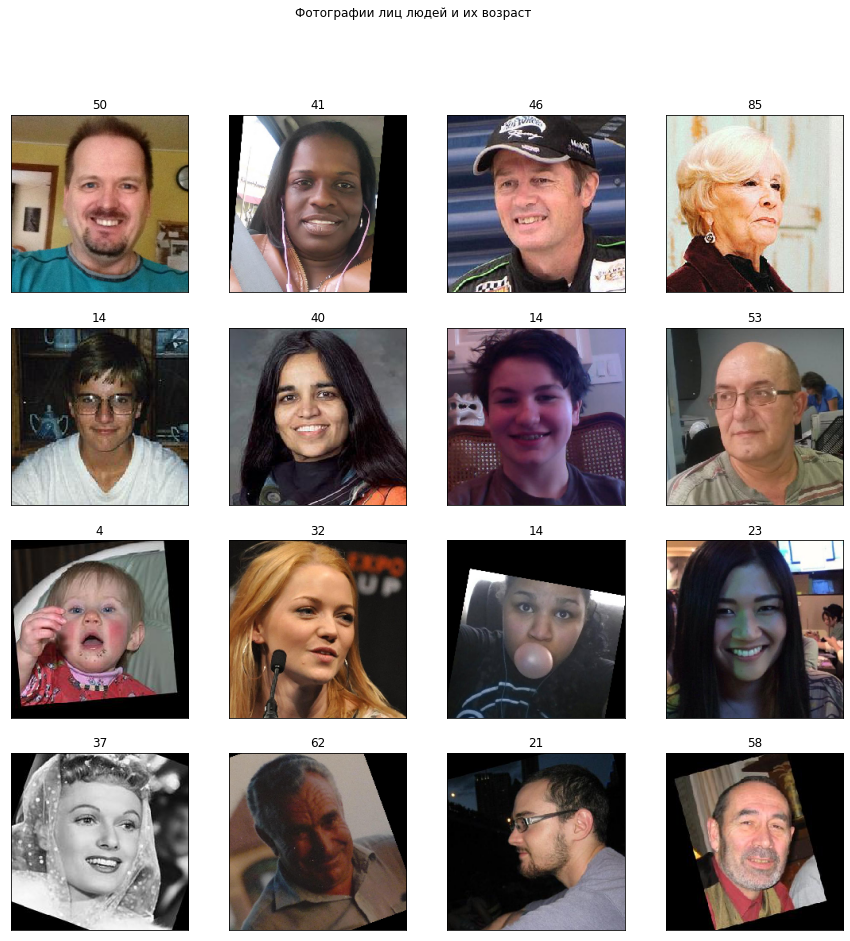

In [7]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('Фотографии лиц людей и их возраст') 
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features_train[i])#.set_title('Нормальное распределение')
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.gca().set_title(target_train[i])
    plt.xticks([])
    plt.yticks([])
    #plt.tight_layout()

## Вывод

В выборке 7591 фотографий,
Средний возраст 31 год, медианный 29.
В выборке мало фотографий детей около 10 лет
Фотографии в выборке как цветные, так и чернобелые, есть фотографии со смещением.
На фотографиях лица приведены крупным планом, они выровнены вертикально, размер лиц на фото примерно одинаков.

# Обучение модели

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
from tensorflow import keras

def load_train(path):
    labels = pd.read_csv( path + 'labels.csv' )
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        #vertical_flip=True,
        #rotation_range = 15,
        #width_shift_range=0.2,
        #height_shift_range=0.2
        )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv( path + 'labels.csv' )
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
        )
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
  backbone = ResNet50(input_shape=input_shape,#(224, 224, 3),
                      weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                      include_top=False) 

  model = Sequential()
  model.add(backbone)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1, activation='relu')) 
  opt = keras.optimizers.SGD(learning_rate=0.001)
  model.compile(loss='mae', 
                optimizer=opt, metrics=['mae'])
  return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, 
               steps_per_epoch=None, validation_steps=None):
  
  model.fit(train_data, 
        validation_data=test_data,
        batch_size=batch_size, 
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2) 
  return model

```

## Вывод 

Результаты обучения модели
```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-08-03 10:37:18.164918: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-03 10:37:18.456359: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 45s - loss: 14.3447 - mae: 14.3455 - val_loss: 22.7643 - val_mae: 22.7630
Epoch 2/10
178/178 - 38s - loss: 7.8636 - mae: 7.8641 - val_loss: 16.4793 - val_mae: 16.4524
Epoch 3/10
178/178 - 38s - loss: 6.4442 - mae: 6.4444 - val_loss: 12.7487 - val_mae: 12.7261
Epoch 4/10
178/178 - 38s - loss: 5.4437 - mae: 5.4442 - val_loss: 13.0741 - val_mae: 13.0439
Epoch 5/10
178/178 - 38s - loss: 4.9042 - mae: 4.9039 - val_loss: 8.3704 - val_mae: 8.3978
Epoch 6/10
178/178 - 38s - loss: 4.4506 - mae: 4.4508 - val_loss: 6.9879 - val_mae: 7.0146
Epoch 7/10
178/178 - 38s - loss: 4.1205 - mae: 4.1206 - val_loss: 6.8958 - val_mae: 6.9133
Epoch 8/10
178/178 - 38s - loss: 3.7360 - mae: 3.7362 - val_loss: 6.9626 - val_mae: 6.9740
Epoch 9/10
178/178 - 38s - loss: 3.5128 - mae: 3.5128 - val_loss: 6.7936 - val_mae: 6.8220
Epoch 10/10
178/178 - 38s - loss: 3.2710 - mae: 3.2713 - val_loss: 6.5640 - val_mae: 6.5868
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 6.5640 - mae: 6.5868
Test MAE: 6.5868
```

# Анализ обученной модели

Выполнен анализ данных:

В выборке 7591 фотографий, Средний возраст - 31 год, медианный - 29. В выборке относительно мало фотографий детей примерно 10-15 лет. В выборке присутствуют и цветные, и чернобелые фото. На фотографиях оставлены лица крупным планом в примерно едином масштабе, поэтому есть фотографии с обрезкой и смещением.
Обучена модель, которая по лицу примерно определяет возраст, МAE модели менее 7 лет.

Построенная модель имеет архитектуру ResNet50, т.е. сеть имеет 50 слоев, последний слой содержит 1 нейрон с функцией активации 'relu'.
Для обучения модели использованы: оптимизатор - SGD (LR=0.001); функция потерь и метрика качества - MAE.

Модель позволит по фотофиксации в прикассовой зоне определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Однако вторая цель - контроль продажи алкоголя не достигнута, т.к. модель имеет относительно большое MAE - 7 лет, и надежно проконтролировать продажу алкоголя не удастся. 